In [ ]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append('..')
from utils.utils import process_multiple_markets_cnn, process_multiple_markets
from utils.data_utils import DataPreprocessor
from models.cnn import CNN


In [ ]:
data_preprocessor = DataPreprocessor()
df_per_match = data_preprocessor.extract_match_data()

In [ ]:
# X_train, y_train, X_val, y_val, X_test, y_test = process_multiple_markets(df_per_match)
# print(X_train.shape, y_train.shape)

# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)
# np.save('X_val.npy', X_val)
# np.save('y_val.npy', y_val)
# np.save('X_test.npy', X_test)
# np.save('y_test.npy', y_test)

In [ ]:
# X_train, y_train, X_val, y_val, X_test, y_test = process_multiple_markets_cnn(df_per_match)
# print(X_train.shape, y_train.shape)


# np.save('X_train_cnn.npy', X_train)
# np.save('y_train_cnn.npy', y_train)
# np.save('X_val_cnn.npy', X_val)
# np.save('y_val_cnn.npy', y_val)
# np.save('X_test_cnn.npy', X_test)
# np.save('y_test_cnn.npy', y_test)

In [3]:
X_train = np.load('X_train_cnn.npy')
y_train = np.load('y_train_cnn.npy')
X_val = np.load('X_val_cnn.npy')
y_val = np.load('y_val_cnn.npy')
X_test = np.load('X_test_cnn.npy')
y_test = np.load('y_test_cnn.npy')

In [4]:
def normalize_data(X_train, X_val, X_test):
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data (only on the features, not the labels)
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    # Transform the training, validation, and test data
    X_train_normalized = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_normalized = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_normalized = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    return X_train_normalized, X_val_normalized, X_test_normalized

X_train_normalized, X_val_normalized, X_test_normalized = normalize_data(X_train, X_val, X_test)

In [5]:
def prepare_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = prepare_data_loaders(X_train_normalized, y_train, X_val_normalized, y_val, X_test_normalized, y_test)
X_item, y_item = next(iter(train_loader))
X_item.shape, y_item.shape

(torch.Size([64, 10, 15]), torch.Size([64, 3]))

# Model Training

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Initialize lists to store loss values
    train_losses = []
    val_losses = []

    # Initialize the tqdm progress bar
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for epoch in pbar:
        model.train()
        running_loss = 0.0

        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)  # outputs shape: [batch_size, num_runners, num_classes]
            outputs = outputs.permute(0, 2, 1).contiguous().view(-1, 2)  # Reshape for loss: [batch_size * num_runners, num_classes]
            labels = labels.view(-1)  # Reshape labels for loss: [batch_size * num_runners]
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                outputs = outputs.permute(0, 2, 1).contiguous().view(-1, 2)
                labels = labels.view(-1)
                val_loss = criterion(outputs, labels.long())
                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update the progress bar with training and validation loss
        pbar.set_postfix({'Train Loss': f'{avg_train_loss:.4f}', 'Val Loss': f'{avg_val_loss:.4f}'})
    
    # Return the lists of training and validation losses
    return train_losses, val_losses


In [7]:
# Update the number of classes to 2 for binary classification
input_dim = torch.tensor(X_train, dtype=torch.float32).shape[2]  # Number of features per time step
sequence_length = torch.tensor(X_train, dtype=torch.float32).shape[1]  # Length of the input sequence

num_classes = 2  # Up or Down

# Re-initialize the model with 2 classes
model = CNN(input_dim=input_dim, sequence_length=sequence_length, num_classes=num_classes, num_runners=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 3000

# Train the model with the updated dataset and binary classification
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Training: 100%|██████████| 3000/3000 [1:40:52<00:00,  2.02s/epoch, Train Loss=0.3145, Val Loss=0.4599]  


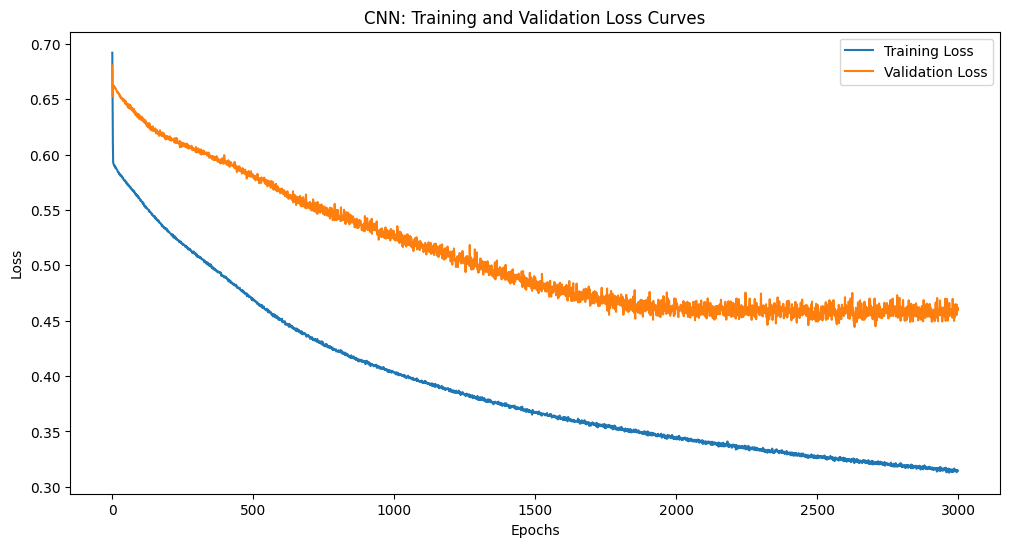

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN: Training and Validation Loss Curves')
plt.legend()
plt.show()

In [9]:
def evaluate_model(model, loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in loader:
            outputs = model(sequences)  # outputs shape: [batch_size, num_runners, num_classes]
            _, preds = torch.max(outputs, 2)  # Get the index of the max log-probability for each runner
            all_predictions.append(preds.numpy())
            all_labels.append(labels.numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_labels, all_predictions
    
def evaluate_on_test_set(model, test_loader, num_runners=3):
    labels, predictions = evaluate_model(model, test_loader)

    for i in range(num_runners):
        runner_labels = labels[:, i]
        runner_predictions = predictions[:, i]

        accuracy = accuracy_score(runner_labels, runner_predictions)
        precision = precision_score(runner_labels, runner_predictions, average='binary')
        recall = recall_score(runner_labels, runner_predictions, average='binary')
        f1 = f1_score(runner_labels, runner_predictions, average='binary')

        print(f'Runner {i+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Evaluate the model on the test set
evaluate_on_test_set(model, test_loader)

Runner 1 - Accuracy: 0.6903, Precision: 0.6435, Recall: 0.5310, F1-score: 0.5819
Runner 2 - Accuracy: 0.4851, Precision: 0.4985, Recall: 0.6067, F1-score: 0.5473
Runner 3 - Accuracy: 0.7635, Precision: 0.6168, Recall: 0.5968, F1-score: 0.6066
